In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import r2_score, rmse
from darts.datasets import EnergyDataset
from darts.utils.statistics import plot_acf, check_seasonality


/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Loading Data

In [2]:
df = pd.read_csv('df_clean.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')

In [3]:
df.head(135)

,date,Price
0,2020-01-01 00:00:00,33.42
1,2020-01-01 01:00:00,31.77
2,2020-01-01 02:00:00,31.57
3,2020-01-01 03:00:00,31.28
4,2020-01-01 04:00:00,30.85
...,...,...
130,2020-01-06 10:00:00,32.01
131,2020-01-06 11:00:00,31.23
132,2020-01-06 12:00:00,31.19
133,2020-01-06 13:00:00,31.08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29712 entries, 0 to 29714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    29712 non-null  datetime64[ns]
 1   Price   29712 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 696.4 KB


In [5]:
df.isna().sum()

date     0
Price    0
dtype: int64

In [6]:
series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq="H")

In [7]:
x = series.pd_dataframe()
x.isna().sum() 

component
Price    0
dtype: int64

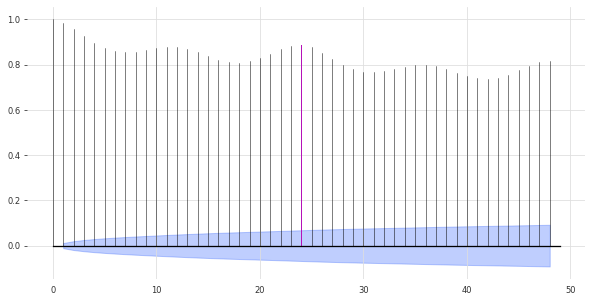

In [8]:
plot_acf(series, m=24, max_lag=48)

In [9]:
check_seasonality(series, m=24, max_lag=48)

# "max lag" refers to the maximum number of time steps or periods that you want to consider when analyzing the relationship between data points in a time series. It represents the farthest point in the past that you believe may have an impact on the current value of the series.

# For example, if you are analyzing daily temperature data and you set the max lag to 7, it means you are considering the temperature values of the past seven days to potentially influence the current day's temperature.

# In our case, we have hourly prices which we belive might be impacted from last days value as well. So, we will be using 48 as our max lag. 


# "m" refers to the seasonality period or the length of a seasonal cycle within the data. It represents the number of time steps or periods required for the series to repeat its pattern. In our case the prices might repeat every 24 hours, so we have m set to 24.

(True, 24)

# NBEATS model

In [10]:
import mlflow

mlflow.set_experiment("price_predictor_final_new")

<Experiment: artifact_location='file:///workspace/code/ulllu/mlruns/679714727224296837', creation_time=1684801902761, experiment_id='679714727224296837', last_update_time=1684801902761, lifecycle_stage='active', name='price_predictor_final_new', tags={}>

### Run 1

In [11]:
# Start an MLflow run
mlflow.start_run(run_name="nbeats_pred", nested=True)

<ActiveRun: >

In [12]:
#mlflow.pytorch.autolog() # Auto logs all params

mlflow.log_param('input_chunk_length', 168)
mlflow.log_param('output_chunk_length', 24)
mlflow.log_param('batch_size', 800)
mlflow.log_param('model_name', "nbeats_run")
mlflow.log_param('n_epochs', 10)


# Log parameters
model_nbeats = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [13]:
model_nbeats.fit(series, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, n_epochs=10, nr_epochs_val_period=1, batch_size=800, model_name=nbeats_run)

In [14]:
pred = model_nbeats.predict(24)

#this doesnot work that good, only gives first few prediction as correct then goes wrong if we set n = len(test)
#this happens because it doesnot retrain on the new data rather just simply uses the data till now to make all future predictions

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [15]:
pred

<TimeSeries (DataArray) (date: 24, component: 1, sample: 1)>
array([[[ 81.99815276]],

       [[ 83.18655617]],

       [[ 81.25090068]],

       [[ 77.97851237]],

       [[ 83.02327375]],

       [[ 95.36279501]],

       [[102.54936483]],

       [[125.20776363]],

       [[110.14532336]],

       [[ 87.12166002]],

...

       [[ 43.85187363]],

       [[ 53.18687087]],

       [[ 55.29751273]],

       [[ 65.47595674]],

       [[ 87.71862349]],

       [[ 94.01146971]],

       [[ 89.69155493]],

       [[ 84.31387853]],

       [[ 84.69505861]],

       [[ 66.12409624]]])
Coordinates:
  * date       (date) datetime64[ns] 2023-05-23 ... 2023-05-23T23:00:00
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

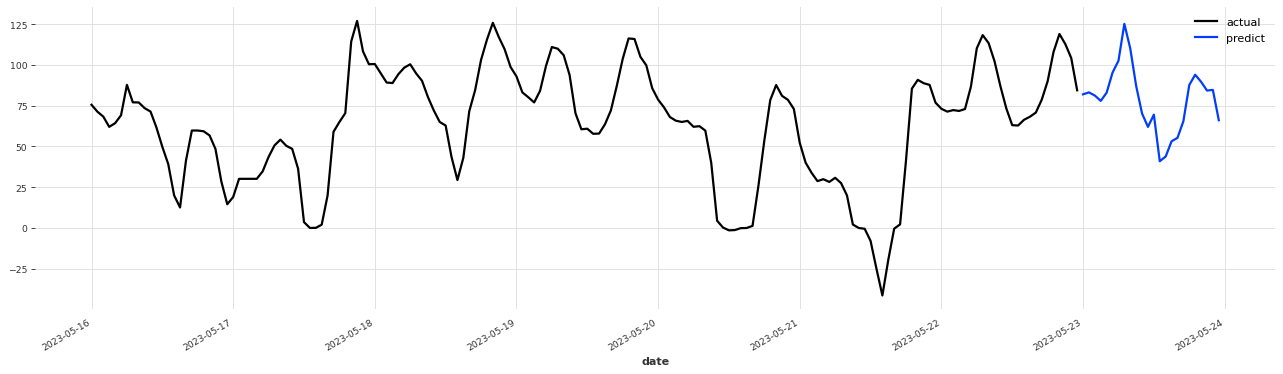

In [23]:
plt.figure(figsize=(20, 5), dpi=80)
series[-168:].plot(label="actual")
pred.plot(label="predict")
plt.show()

# The small gap is because its two different time series, the end of one is at 23:00 for ex and the other begins at 00:00

In [ ]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/price_predictor"
model_version = mlflow.register_model(model_uri, "model_nbeats_pred")

In [ ]:
mlflow.end_run()